In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as pyo
import numpy as np
from plotly.subplots import make_subplots
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

2023-06-25 19:49:33.239319: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-25 19:49:33.407193: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-25 19:49:33.408144: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-25 19:49:34.471556: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv('merged_df.csv')

def _compute_vd_helper(volume: float, taker_buy_volume: float) -> float:
    
    vd = 2*taker_buy_volume - volume
    return vd

df['volume_delta_base_asset'] = df.apply(lambda x: _compute_vd_helper(x.volume,
                                         x.taker_buy_base_asset_volume), axis=1)

df['returns'] = (df.close - df.open)/df.open
df['algo_funding'] = 100 * df['fundingRate']

df['gain'] = pd.Series([1 if val > 0 else 0 for val in df.returns])

In [4]:
# Set the percentage of training data
train_data_percentage = 0.5

# Prepare your feature matrix and target variable
X = df[['open', 'high', 'low', 'close', 
        'volume', 'quote_asset_volume', 'number of trades',
        'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume',
        'fundingRate', 'volume_delta_base_asset', 'algo_funding']].shift(periods=-1)
X = X.drop(X.index[-1])
X = X.drop(X.index[0])
X = X.values
# X = df[['volume', 'algo_funding', 'volume_delta_base_asset']].values
y = df['gain']
y = y.drop(y.index[-1])
y = y.drop(y.index[0])
y = y.values

# Normalize the features
X = (X - X.mean()) / X.std()

# Split the data into training and testing sets

# Calculate the number of samples for training based on the percentage
num_train_samples = int(train_data_percentage * len(X))

# Split the data into training and testing sets
X_train = X[:num_train_samples]
X_test = X[num_train_samples:]
y_train = y[:num_train_samples]
y_test = y[num_train_samples:]

# Reshape the input data to match LSTM input shape (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [8]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(32, input_shape=(1, X_train.shape[2])))  # 32 is the number of LSTM units
model.add(Dense(64, activation='relu'))  # Additional dense layer
model.add(Dense(128, activation='relu'))  # Additional dense layer
model.add(Dense(256, activation='relu'))  # Additional dense layer
model.add(Dense(512, activation='relu'))  # Additional dense layer
model.add(Dense(1024, activation='relu'))  # Additional dense layer
model.add(Dense(512, activation='relu'))  # Additional dense layer
model.add(Dense(256, activation='relu'))  # Additional dense layer
model.add(Dense(128, activation='relu'))  # Additional dense layer
model.add(Dense(64, activation='relu'))  # Additional dense layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Convert the probabilities to class labels
y_pred_classes = np.round(y_pred).flatten()

# Compare the predicted classes with the true labels
accuracy = np.mean(y_pred_classes == y_test)
print("Test Accuracy:", accuracy)

# Save the trained model
model.save('lstm_model.h5')

Epoch 1/100


2023-06-14 18:06:10.306980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-14 18:06:10.308502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-14 18:06:10.312647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - 3s 16ms/step - loss: 0.6932 - accuracy: 0.5149
Epoch 2/100
21/21 [==============================] - 0s 19ms/step - loss: 0.6929 - accuracy: 0.5253
Epoch 3/100
21/21 [==============================] - 0s 17ms/step - loss: 0.6924 - accuracy: 0.5253
Epoch 4/100
21/21 [==============================] - 0s 17ms/step - loss: 0.6922 - accuracy: 0.5253
Epoch 5/100
21/21 [==============================] - 0s 17ms/step - loss: 0.6932 - accuracy: 0.5253
Epoch 6/100
21/21 [==============================] - 0s 17ms/step - loss: 0.6928 - accuracy: 0.5417
Epoch 7/100
21/21 [==============================] - 0s 17ms/step - loss: 0.6928 - accuracy: 0.4970
Epoch 8/100
21/21 [==============================] - 0s 18ms/step - loss: 0.6911 - accuracy: 0.5253
Epoch 9/100
21/21 [==============================] - 0s 18ms/step - loss: 0.6930 - accuracy: 0.5253
Epoch 10/100
21/21 [==============================] - 0s 20ms/step - loss: 0.6915 - accuracy: 0.5253
Epoch 11/10

2023-06-14 18:06:46.342755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-14 18:06:46.344025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-14 18:06:46.344951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - 0s 3ms/step
Test Accuracy: 0.4732142857142857


In [10]:
df = df[-len(X_test):]
df = df.reset_index(drop=True)

# create subplots with two y-axes
fig = make_subplots(specs=[[{"secondary_y": True}]])

df['weak_buy'] = y_pred_classes # df.apply(weak_buy, axis=1).shift(1)

fig.add_trace(go.Candlestick(
    x=pd.to_datetime(df['open time'], unit='ms'),
    open=df.open,
    high=df.high,
    low=df.low,
    close=df.close,
    increasing=dict(line=dict(color='green')),
    decreasing=dict(line=dict(color='red')),
    name='Price')
)

fig.add_trace(go.Scatter(
    x=pd.to_datetime(df['open time'][df.weak_buy > 0], unit='ms'),
    y=-3000+df.low[df.weak_buy > 0],
    name='weak buy',
    mode='markers',
    marker=dict(
        symbol='triangle-up',
        size=10,
        color='blue',
        line=dict(width=1, color='blue'),
    )
))

pio.write_image(fig, 'trade_entries_chart.jpeg', format='png')
pyo.plot(fig, filename='plot.html', auto_open=True)

'plot.html'

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/lib/p

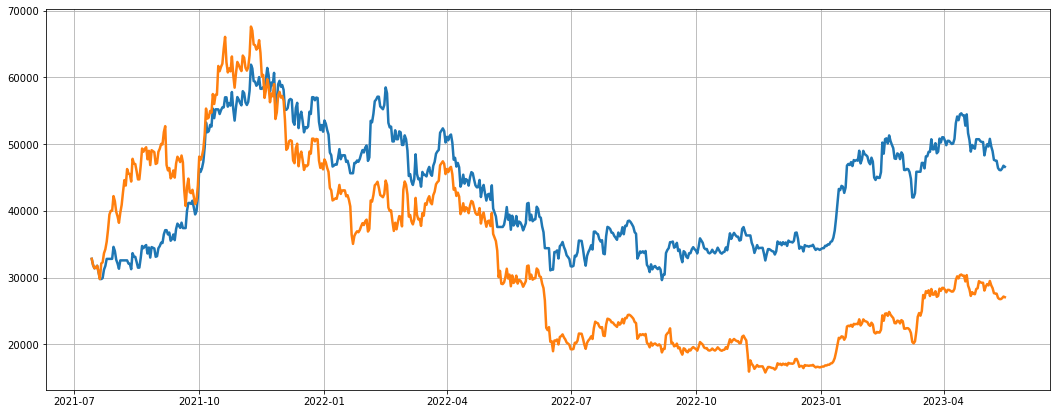

In [11]:
# Create a new column for the equity curve
df['equity_curve'] = 1.0  # Initial value of 1.0

# Iterate through the DataFrame rows
for i in range(1, len(df)):
    # Compute equity curve based on buy signals and percentage returns
    if df.weak_buy.iloc[i] == 1:
        df.equity_curve.at[i] = df.equity_curve.iloc[i-1] * (1 + df.returns.iloc[i])
    else:
        df.equity_curve.at[i] = df.equity_curve.iloc[i-1]

# Create a larger figure
plt.figure(figsize=(18, 7))  # Set the width to 8 inches and height to 6 inches
plt.grid(True)
plt.plot(pd.to_datetime(df['open time'], unit='ms'), df.equity_curve*df.close.iloc[0], linewidth=2.5)
plt.plot(pd.to_datetime(df['open time'], unit='ms'), df.close, linewidth=2.5)
plt.savefig('equity_curve_lstm.png')

In [14]:
import numpy as np


def calculate_returns(equity_curve: np.array) -> np.array:

    returns = np.diff(equity_curve)/equity_curve[:-1]

    return returns


def calculate_max_drawdown(equity_curve: np.array) -> np.array:
    
    m_max = 0.
    maxDD = 0.

    for i in range(equity_curve.shape[0]):
        m_max = max(m_max, equity_curve[i])
        maxDD = min(maxDD, equity_curve[i]/m_max - 1)

    return round(maxDD, 3)


def calculate_sharpe(returns: np.array) -> np.array:
    
    gap = 1./24
    mean = returns.mean()
    std = returns.std()

    sharpe = round(mean / std * np.sqrt(365/gap), 2) if std != 0 else 0

    return sharpe


def calculate_sortino(returns: np.array) -> np.array:
    
    gap = 1./24
    mean = returns.mean()
    downside = (np.square(returns[returns < 0])).sum()
    downside_dev = np.sqrt(downside/returns.size)

    sortino = round(mean / downside_dev * np.sqrt(365/gap), 2)\
        if downside_dev != 0 else 0

    return sortino


def calculate_omega(returns: np.array) -> np.array:

    positive_area = returns[returns > 0].sum()
    negative_area = -returns[returns < 0].sum()

    omega = round(positive_area / negative_area, 2)\
        if negative_area != 0 else 0

    return omega


def get_stats(equity_curve: np.array) -> dict:

    returns = calculate_returns(equity_curve)
    mean = returns.mean()
    std = returns.std()
    max_dd = calculate_max_drawdown(equity_curve)
    sharpe = calculate_sharpe(returns)
    sortino = calculate_sortino(returns)
    omega = calculate_omega(returns)

    return {'returns': returns, 'mean': mean, 'std': std,
            'max_dd': max_dd, 'sharpe': sharpe,
            'sortino': sortino, 'omega': omega}


def print_stats(equity_curve: np.array) -> None:

    stats = get_stats(equity_curve)

    print('Mean:            {:.2%}'.format(stats['mean']))
    print('Standard Deviation: {:.2%}'.format(stats['std']))
    print('Max Drawdown:    {:.2%}'.format(stats['max_dd']))
    print('Sharpe Ratio:    {:.2f}'.format(stats['sharpe']))
    print('Sortino Ratio:   {:.2f}'.format(stats['sortino']))
    print('Omega Ratio:     {:.2f} '.format(stats['omega']))

print('\n Equity Curve \n')
print_stats(df.equity_curve)
print('\n Buy and Hold \n')
print_stats(df.close)

print('\n', df.equity_curve.iloc[-1])


 Equity Curve 

Mean:            0.09%
Standard Deviation: 2.69%
Max Drawdown:    -52.20%
Sharpe Ratio:    3.07
Sortino Ratio:   4.63
Omega Ratio:     1.10 

 Buy and Hold 

Mean:            0.02%
Standard Deviation: 3.27%
Max Drawdown:    -76.70%
Sharpe Ratio:    0.71
Sortino Ratio:   1.01
Omega Ratio:     1.02 

 1.4204581825274498


In [9]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('lstm_model.h5')

# Use the loaded model for prediction or evaluation
predictions = loaded_model.predict(X_test)

# Convert the probabilities to class labels
y_pred_classes = np.round(predictions).flatten()

2023-06-25 19:51:08.905793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 19:51:08.907293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 19:51:08.908205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - 0s 3ms/step


2023-06-25 19:51:09.257453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 19:51:09.258985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 19:51:09.259982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus